In [ ]:
import pandas as pd
import numpy as np
from random import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import files
files.upload()

In [ ]:
salaries = pd.read_csv("./clean_kaggle_data_2022.csv", low_memory = False, encoding = 'latin2')
salaries.shape

(8137, 298)

In [ ]:
salaries.head()

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,...,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,"Are you currently a student? (high school, uni...",On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,NaN,NaN
1,851,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,"Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,2.0,"20,000-29,999"
2,501,30-34,Man,Germany,No,Coursera,edX,NaN,NaN,NaN,...,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
3,787,70+,Man,Australia,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,NaN,NaN,"Podcasts (Chai Time Data Science, OEEReilly...",NaN,NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
4,1132,40-44,Man,United States of America,No,Coursera,NaN,Kaggle Learn Courses,NaN,Fast.ai,...,NaN,NaN,"Podcasts (Chai Time Data Science, OEEReilly...","Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,13.0,"200,000-299,999"


# Question 1: Data Cleaning

- Drop the second row since it is about the question details
- Drop other columns if they are irrelevant to the task

In [ ]:
def CleanData(df):
    # Drop the first row (question details)
    df.drop(df.index[0], inplace=True)

    # Drop other information too here if they are irrelevant to the task
    salaries.drop('Duration (in seconds)', axis = 1, inplace = True)

    return df

salaries = CleanData(salaries)
salaries.shape

(8136, 297)

###**Handling categorical features (multi column responses)**

In [ ]:
#Identify multi-column responses
multi_col_names = []
for col in salaries.columns:
  if "_" in col:
    multi_col_names.append(col)

multi_col_names.remove("Q29_Encoded")
multi_col_names.remove("Q29_buckets")

#Address missing values in the multi-column responses and and perform encoding for categorical features
for col in multi_col_names:
  salaries[col] = salaries[col].fillna(0) #fill nan with 0
  salaries[col] = np.where((salaries[col] != 0), 1, salaries[col]) #change string to 1

#drop columns with values "Other"
col_others = ["Q6_12", "Q7_7", "Q12_15", "Q13_14", "Q14_16", "Q15_15", "Q17_15",
              "Q18_14", "Q19_8", "Q20_6", "Q21_10", "Q28_8", "Q31_12", "Q33_5",
              "Q34_8", "Q35_16", "Q36_15", "Q37_13", "Q38_8", "Q39_12", "Q40_15",
              "Q41_9", "Q42_9", "Q44_12"]

salaries = salaries.drop(col_others, axis=1)

In [ ]:
#current look
salaries.head()

,Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,...,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q29_Encoded,Q29_buckets
1,55-59,Man,France,No,1,0,1,0,0,0,...,1,1,0,0,1,0,0,0,2.0,"20,000-29,999"
2,30-34,Man,Germany,No,1,1,0,0,0,1,...,0,0,1,0,1,0,0,0,10.0,"100,000-124,999"
3,70+,Man,Australia,No,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,10.0,"100,000-124,999"
4,40-44,Man,United States of America,No,1,0,1,0,1,1,...,0,0,0,1,1,0,0,0,13.0,"200,000-299,999"
5,40-44,Man,United States of America,No,1,0,0,0,0,1,...,0,0,0,1,1,1,0,0,13.0,"200,000-299,999"


In [ ]:
#current shape
salaries.shape

(8136, 273)

I dropped columns that contain response "Other" because they don't provide any information.

###**Impute missing values (single column responses)**

1. Identify columns with single column responses

2. Address missing values in those columns

In [ ]:
def ImputingSingleColMissingValues(df):
    # Tips: Include Q29_Encoded (target) in the single_col_names
    # so that its row size stays same as other rows after data preprocessing
    # extract single column names and store them as a list
    single_col_names = []
    for col in df.columns:
      if "_" not in col:
        single_col_names.append(col)

    single_col_names.append("Q29_Encoded")
    print("Percentage of null values: ")
    print(df[single_col_names].isnull().sum()*100/len(df))


    #address missing values in single column responses in df
    col_delete = []
    for col in single_col_names:
      #if too many missing values, then just drop this column
      if df[col].isnull().sum()*100/len(df) > 70:
        col_delete.append(col)
      else:
      #fill with unknown to show missingness for now
        df[col].fillna("unknown", inplace = True)


    #drop columns with too many missing values
    for col in col_delete:
      df.drop(col, axis = 1, inplace = True)
      single_col_names.remove(col)
      print(col+" is dropped!")

    print("Percentage of null values (make sure they are all zeros): ")
    print(df[single_col_names].isnull().sum()*100/len(df))
    assert df[single_col_names].isnull().values.sum() == 0, \
        "There are still missing values remaining!"

    return df

salaries = ImputingSingleColMissingValues(salaries)

Percentage of null values: 
Q2              0.000000
Q3              0.000000
Q4              0.000000
Q5              0.000000
Q8              0.000000
Q9             36.147984
Q11             0.000000
Q16             8.407080
Q22            80.162242
Q23             0.000000
Q24             0.000000
Q25             0.000000
Q26             0.000000
Q27             0.000000
Q29             0.000000
Q30             0.614553
Q32            77.126352
Q43            45.759587
Q29_Encoded     0.000000
dtype: float64
Q22 is dropped!
Q32 is dropped!
Percentage of null values (make sure they are all zeros): 
Q2             0.0
Q3             0.0
Q4             0.0
Q5             0.0
Q8             0.0
Q9             0.0
Q11            0.0
Q16            0.0
Q23            0.0
Q24            0.0
Q25            0.0
Q26            0.0
Q27            0.0
Q29            0.0
Q30            0.0
Q43            0.0
Q29_Encoded    0.0
dtype: float64


I first examined their pecentage of missing values. I dropped column 'Q22' and 'Q32' because I think they are irrelavant information to the task and the percentage of missing values is too high (around 80%). For other columns with missing values, I replaced nan with "unknown" to show missingness for now. I chose to do this instead of simply removing rows or columns with missing values because I want to preserve the data size and number of features as much as possible so that I have enough data and keep all potentially important features for analysis later.

###**Encode categorical features (sinlge column responses)**

#### Q2 ####

I used ordinal encoding because age groups have order.

In [ ]:
#check values of Q2
salaries['Q2'].value_counts()

25-29    1604
30-34    1430
35-39    1207
40-44    1037
22-24     743
45-49     701
50-54     567
55-59     359
60-69     341
18-21      83
70+        64
Name: Q2, dtype: int64

In [ ]:
#Encode categorical features in the single column responses
#Encode Q2
#use ordinal encoding
Q2_encoding = {
    "18-21": 0,
    "22-24": 1,
    "25-29": 2,
    "30-34": 3,
    "35-39": 4,
    "40-44": 5,
    "45-49": 6,
    "50-54": 7,
    "55-59": 8,
    "60-69": 9,
    "70+": 10
}
salaries['Q2'] = salaries['Q2'].map(Q2_encoding)

#### Q3 ####

I used one-hot encoding and deleted rows with value 'Prefer not to say','Prefer to self-describe' because they dont' provide any information on sex distribution and the number of these type of rows is small. So deleting these rows would not lose many data.

In [ ]:
#check values of Q3
salaries['Q3'].value_counts()

Man                        6635
Woman                      1382
Prefer not to say            89
Nonbinary                    22
Prefer to self-describe       8
Name: Q3, dtype: int64

In [ ]:
#Encode Q3
#use dummy variables
salaries = pd.get_dummies(salaries, columns=['Q3'])
#drop 'Prefer not to say' & 'Prefer to self-describe'
salaries = salaries.drop(['Q3_Prefer not to say','Q3_Prefer to self-describe'], axis=1)

#### Q4 ####

Since there are too many countries and counts are sparse, one-hot encoding for each country will not be ideal. So I grouped countries based on income groups that are categorized by World Bank (https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups)

*   Not classified: 0
*   Low-income economies: 1
*   Lower-Middle income economies: 2
*   Upper-Middle income economies: 3
*   High-income economies: 4


In [ ]:
#check values of Q4
salaries['Q4'].value_counts()

India                                                   2328
United States of America                                1434
Other                                                    511
Japan                                                    333
Brazil                                                   292
Nigeria                                                  159
Spain                                                    140
United Kingdom of Great Britain and Northern Ireland     139
Mexico                                                   139
France                                                   137
South Korea                                              131
Pakistan                                                 131
Canada                                                   117
Turkey                                                   114
Taiwan                                                   110
China                                                    108
Indonesia               

Categorized countries into different income groups based on World Bank definition(https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups)

*   Not classified: 0
*   Low-income economies: 1
*   Lower-Middle income economies: 2
*   Upper-Middle income economies: 3
*   High-income economies: 4


In [ ]:
#Encode Q4
Q4_encoding = {
    "India": 2,
    "United States of America": 4,
    "Other": 0,
    "Japan": 4,
    "Brazil": 3,
    "Nigeria": 2,
    "Spain": 4,
    "United Kingdom of Great Britain and Northern Ireland": 4,
    "Mexico": 3,
    "France": 4,
    "South Korea": 4,
    "Pakistan": 2,
    "Canada": 4,
    "Turkey": 0,
    "Taiwan": 4,
    "China": 3,
    "Indonesia": 3,
    "Russia": 3,
    "Egypt": 2,
    "Italy": 4,
    "Colombia": 3,
    "Poland": 4,
    "Argentina": 3,
    "Netherlands": 4,
    "Australia": 4,
    "Germany": 4,
    "Viet Nam": 2,
    "Chile": 4,
    "United Arab Emirates": 4,
    "Thailand": 3,
    "Philippines": 2,
    "Bangladesh": 2,
    "Kenya": 2,
    "Portugal": 4,
    "Morocco": 2,
    "Israel": 4,
    "Peru": 3,
    "South Africa": 3,
    "Singapore": 4,
    "Saudi Arabia": 4,
    "Belgium": 4,
    "Ethiopia": 1,
    "Ireland": 4,
    "Iran, Islamic Republic of...": 2,
    "Malaysia": 3,
    "Czech Republic": 4,
    "Hong Kong (S.A.R.)": 4,
    "Ghana": 2,
    "Sri Lanka": 2,
    "Romania": 4,
    "Ukraine": 2,
    "Tunisia": 2,
    "Cameroon": 2,
    "Nepal": 2,
    "Zimbabwe": 2,
    "Ecuador": 3,
    "I do not wish to disclose my location": 0,
    "Algeria": 2,
}
salaries['Q4'] = salaries['Q4'].map(Q4_encoding)

#### Q5 ####

I dropped this column because the whole column only has one value "No" at all, which is useless.

In [ ]:
#check values of Q5
salaries['Q5'].value_counts()

No    8136
Name: Q5, dtype: int64

In [ ]:
#drop Q5
salaries = salaries.drop(['Q5'], axis=1)

#### Q8 ####

I used ordinal encoding becasue education level can be ranked. For values with "I prefer not to answer" I imputed them with mode because there are a decent number of them and I want to preserve these rows but the origninal answer does not fit into any rank.

In [ ]:
#check values of Q8
salaries['Q8'].value_counts()

MasterEEs degree                                                      3567
BachelorEEs degree                                                    2005
Doctoral degree                                                          1349
I prefer not to answer                                                    426
Some college/university study without earning a bachelorEEs degree     304
Professional doctorate                                                    279
No formal education past high school                                      206
Name: Q8, dtype: int64

In [ ]:
#Encode Q8
#use ordinal encoding
Q8_encoding = {
    "No formal education past high school": 0,
    "Some college/university study without earning a bachelorEEs degree": 1,
    "BachelorEEs degree": 2,
    "MasterEEs degree": 3,
    "Professional doctorate": 4,
    "Doctoral degree": 5
}
salaries['Q8'] = salaries['Q8'].map(Q8_encoding)

In [ ]:
#impute mode for "I prefer not to answer"
salaries['Q8'].fillna(salaries['Q8'].mode().iloc[0], inplace = True)

#### Q9 ####

I dropped this column because over 1/3 of them has unknown values and 1/3 is "Yes" while 1/3 is "No" and using mode imputation will create a huge bias.

In [ ]:
#check values of Q9
salaries['Q9'].value_counts()

unknown    2941
Yes        2672
No         2523
Name: Q9, dtype: int64

In [ ]:
#drop Q9
salaries = salaries.drop(['Q9'], axis=1)

#### Q11 ####

I used ordinal encoding because years of experience can be ranked.

In [ ]:
#check values of Q11
salaries['Q11'].value_counts()

1-3 years                    1468
5-10 years                   1394
3-5 years                    1243
10-20 years                  1155
< 1 years                    1148
20+ years                    1044
I have never written code     684
Name: Q11, dtype: int64

In [ ]:
#Encode Q11
#use ordinal encoding
Q11_encoding = {
    "I have never written code": 0,
    "< 1 years": 1,
    "1-3 years": 2,
    "3-5 years": 3,
    "5-10 years": 4,
    "10-20 years": 5,
    "20+ years": 6,
}
salaries['Q11'] = salaries['Q11'].map(Q11_encoding)

#### Q16 ####

I used ordinal encoding because years of experience can be ranked. I use mode to impute unknown values because deleting these rows will lose a lot of data.

In [ ]:
#check values of Q16
salaries['Q16'].value_counts()

Under 1 year                             1724
1-2 years                                1266
I do not use machine learning methods    1107
2-3 years                                 955
5-10 years                                808
unknown                                   684
4-5 years                                 635
3-4 years                                 591
10-20 years                               366
Name: Q16, dtype: int64

In [ ]:
#Encode Q16
#use ordinal encoding
Q16_encoding = {
    "I do not use machine learning methods": 0,
    "Under 1 year": 1,
    "1-2 years": 2,
    "2-3 years": 3,
    "3-4 years": 4,
    "4-5 years": 5,
    "5-10 years": 6,
    "10-20 years": 7
}
salaries['Q16'] = salaries['Q16'].map(Q16_encoding)

In [ ]:
#impute mode for "unknown"
salaries['Q16'].fillna(salaries['Q16'].mode().iloc[0], inplace = True)

#### Q23 ####

I used one-hot encoding because these categories don't have ranking. Then I dropped the column 'Q23_Other' because it doesn't provide any useful information.

In [ ]:
#check values of Q23
salaries['Q23'].value_counts()

Data Scientist                                                      1708
Data Analyst (Business, Marketing, Financial, Quantitative, etc)    1353
Software Engineer                                                    859
Teacher / professor                                                  746
Manager (Program, Project, Operations, Executive-level, etc)         746
Other                                                                682
Research Scientist                                                   525
Machine Learning/ MLops Engineer                                     506
Engineer (non-software)                                              413
Data Engineer                                                        287
Statistician                                                         108
Data Architect                                                        82
Data Administrator                                                    67
Developer Advocate                                 

In [ ]:
#Encode Q23
#use dummy variables
salaries = pd.get_dummies(salaries, columns=['Q23'])
#drop Other
salaries = salaries.drop(['Q23_Other'], axis=1)

#### Q24 ####

I used one-hot encoding because these categories don't have ranking. Then I dropped the column 'Q24_Other' because it doesn't provide any useful information.

In [ ]:
#check values of Q24
salaries['Q24'].value_counts()

Computers/Technology                      2056
Academics/Education                       1299
Accounting/Finance                         729
Other                                      654
Manufacturing/Fabrication                  504
Medical/Pharmaceutical                     454
Government/Public Service                  451
Online Service/Internet-based Services     417
Retail/Sales                               370
Energy/Mining                              288
Insurance/Risk Assessment                  222
Marketing/CRM                              219
Non-profit/Service                         176
Broadcasting/Communications                162
Shipping/Transportation                    135
Name: Q24, dtype: int64

In [ ]:
#Encode Q24
#use dummy variables
salaries = pd.get_dummies(salaries, columns=['Q24'])
#drop Other
salaries = salaries.drop(['Q24_Other'], axis=1)

#### Q25 ####

I used ordinal encoding because company size have ranking.

In [ ]:
#check values of Q25
salaries['Q25'].value_counts()

10,000 or more employees    1914
0-49 employees              1859
1000-9,999 employees        1711
50-249 employees            1429
250-999 employees           1223
Name: Q25, dtype: int64

In [ ]:
#Encode 25
#use ordinal encoding
Q25_encoding = {
    "0-49 employees": 0,
    "50-249 employees": 1,
    "250-999 employees": 2,
    "1000-9,999 employees": 3,
    "10,000 or more employees": 4,
}
salaries['Q25'] = salaries['Q25'].map(Q25_encoding)

#### Q26 ####

I manually corrected the broken inputs and use ordinal encoding because these categories can be ranked.

In [ ]:
#check values of Q26
salaries['Q26'].value_counts()

20+       2061
2-Jan     1658
0         1298
4-Mar     1257
9-May     1029
14-Oct     595
15-19      238
Name: Q26, dtype: int64

In [ ]:
#change broken inputs to correct values
salaries.loc[salaries["Q26"] == "2-Jan", "Q26"] = "1-2"
salaries.loc[salaries["Q26"] == "4-Mar", "Q26"] = "3-4"
salaries.loc[salaries["Q26"] == "9-May", "Q26"] = "5-9"
salaries.loc[salaries["Q26"] == "14-Oct", "Q26"] = "10-14"

#check values of Q26
salaries['Q26'].value_counts()

20+      2061
1-2      1658
0        1298
3-4      1257
5-9      1029
10-14     595
15-19     238
Name: Q26, dtype: int64

In [ ]:
#use ordinal encoding
Q26_encoding = {
    "0": 0,
    "1-2": 1,
    "3-4": 2,
    "5-9": 3,
    "10-14": 4,
    "15-19": 5,
    "20+": 6,
}
salaries['Q26'] = salaries['Q26'].map(Q26_encoding)

#### Q27 ####

I used ordinal encoding because I think the extent to which company utilize ML methods can be ranked. I use mode to impute 'I do not know' values because I want to preserve as much data as possible.

In [ ]:
#check values of Q27
salaries['Q27'].value_counts()

No (we do not use ML methods)                                                                1821
We have well established ML methods (i.e., models in production for more than 2 years)       1645
We are exploring ML methods (and may one day put a model into production)                    1431
I do not know                                                                                1258
We recently started using ML methods (i.e., models in production for less than 2 years)      1132
We use ML methods for generating insights (but do not put working models into production)     849
Name: Q27, dtype: int64

In [ ]:
#Encode 27
#use ordinal encoding
Q27_encoding = {
    "No (we do not use ML methods)": 0,
    "We use ML methods for generating insights (but do not put working models into production)": 1,
    "We are exploring ML methods (and may one day put a model into production)": 2,
    "We recently started using ML methods (i.e., models in production for less than 2 years)": 3,
    "We have well established ML methods (i.e., models in production for more than 2 years)": 4,
}
salaries['Q27'] = salaries['Q27'].map(Q27_encoding)

In [ ]:
#impute mode for "I do not know"
salaries['Q27'].fillna(salaries['Q27'].mode().iloc[0], inplace = True)

#### Q30 ####

I used ordinal encoding because money spent can be ranked from low to high. I used mode to impute unknown values because I want to preserve as much data as possible.

In [ ]:
#check values of Q30
salaries['Q30'].value_counts()

$0 ($USD)                  2653
$100-$999                  1993
$1000-$9,999               1412
$1-$99                     1401
$10,000-$99,999             453
$100,000 or more ($USD)     174
unknown                      50
Name: Q30, dtype: int64

In [ ]:
#Encode 30
#use ordinal encoding
Q30_encoding = {
    "$0 ($USD)": 0,
    "$1-$99": 1,
    "$100-$999": 2,
    "$1000-$9,999": 3,
    "$10,000-$99,999": 4,
    "$100,000 or more ($USD)": 5
}
salaries['Q30'] = salaries['Q30'].map(Q30_encoding)

In [ ]:
#impute mode for "unknown"
salaries['Q30'].fillna(salaries['Q30'].mode().iloc[0], inplace = True)

#### Q43 ####

I used ordinal encoding because frequency can be ranked from never to many times. I used mode to impute unknown values because I want to preserve as much data as possible.

In [ ]:
#check values of Q43
salaries['Q43'].value_counts()

unknown               3723
Never                 2429
2-5 times              922
Once                   586
6-25 times             255
More than 25 times     221
Name: Q43, dtype: int64

In [ ]:
#Encode 43
#use ordinal encoding
Q43_encoding = {
    "Never": 0,
    "Once": 1,
    "2-5 times": 2,
    "6-25 times": 3,
    "More than 25 times": 4
}
salaries['Q43'] = salaries['Q43'].map(Q43_encoding)

In [ ]:
#impute mode for "unknown"
salaries['Q43'].fillna(salaries['Q43'].mode().iloc[0], inplace = True)

In [ ]:
#check the result
salaries.head()

,Q2,Q4,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,...,Q24_Energy/Mining,Q24_Government/Public Service,Q24_Insurance/Risk Assessment,Q24_Manufacturing/Fabrication,Q24_Marketing/CRM,Q24_Medical/Pharmaceutical,Q24_Non-profit/Service,Q24_Online Service/Internet-based Services,Q24_Retail/Sales,Q24_Shipping/Transportation
1,8,4,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,3,4,1,1,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
3,10,4,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,5,4,1,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5,5,4,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


###**Drop the target variable(s) and get the target variable**

In [ ]:
# Make sure there are no missing values remaining in the dataset
assert salaries.isnull().values.sum() == 0, \
    "There are still {} missing values remaining in salaries!".format(
        salaries.isnull().values.sum()
    )

In [ ]:
# get the target variable
target = salaries["Q29_Encoded"]

# Drop the target variables from the feature set
features_set = salaries.copy()
features_set = features_set.drop("Q29_Encoded", axis=1)
features_set = features_set.drop("Q29", axis=1)
features_set = features_set.drop("Q29_buckets", axis=1)

# Make sure the target variables are not included in the feature set
for col in features_set:
    assert 'Q29' not in col, \
        "Target variable ({}) is still in the dataset".format(col)

# Question 2: Exploratory Feature Analysis

- From Question 2 - Question 4, you should **NOT** peek at the test labels in any form!
- Assume that you do not know the target values (Q29_Encoded)

## Split data into training and test sets

In [ ]:
# You can use from sklearn.model_selection.train_test_split()
train_df, test_df, y_train, y_test = train_test_split(features_set, target, random_state = 0, test_size = 0.3)

## **Visualization**

- Make visualization to better understand your data

In [ ]:
#combine features set and target
df = pd.concat([features_set, target], axis=1)

#correlation between variables
df_corr = df.corr()

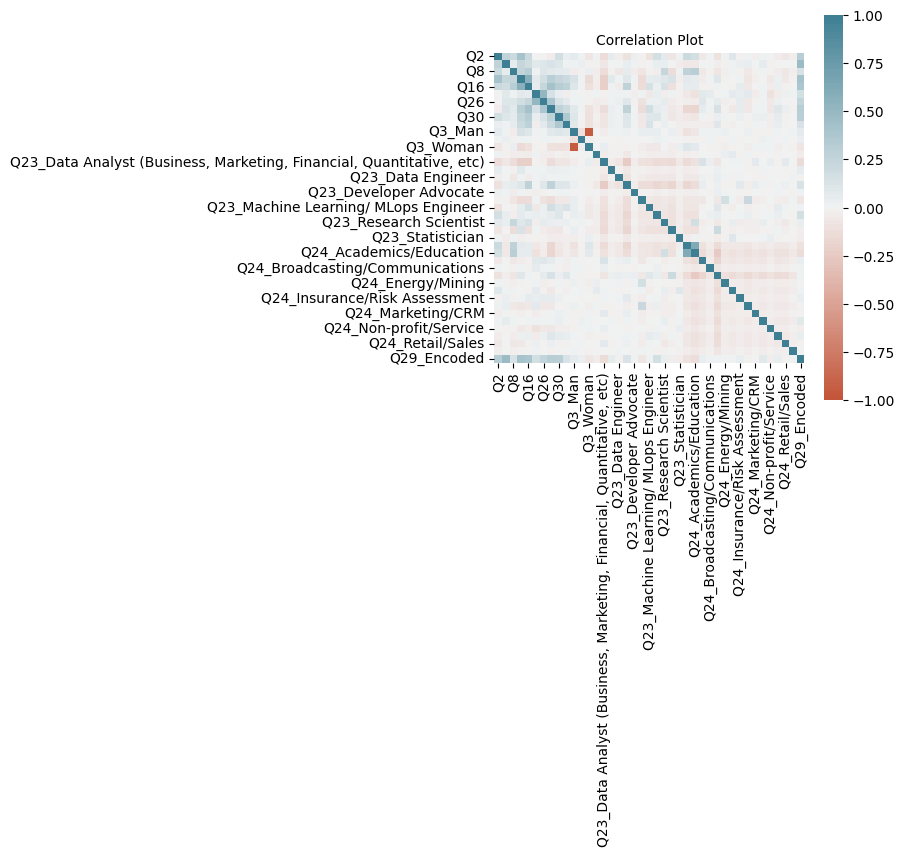

In [ ]:
#correlation plot
plt.figure(figsize=(5,5))
plt.title('Correlation Plot',fontsize = 10)

ax = sns.heatmap(
    df_corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

plt.show()

In [ ]:
#order by feature importance
features_important = pd.DataFrame(df_corr['Q29_Encoded'].sort_values(key=abs,ascending=False))
features_important

,Q29_Encoded
Q29_Encoded,1.000000
Q4,0.469402
Q11,0.406746
Q16,0.385459
Q2,0.315812
Q27,0.314579
Q30,0.297743
Q26,0.255693
"Q23_Manager (Program, Project, Operations, Executive-level, etc)",0.171829
Q25,0.165711


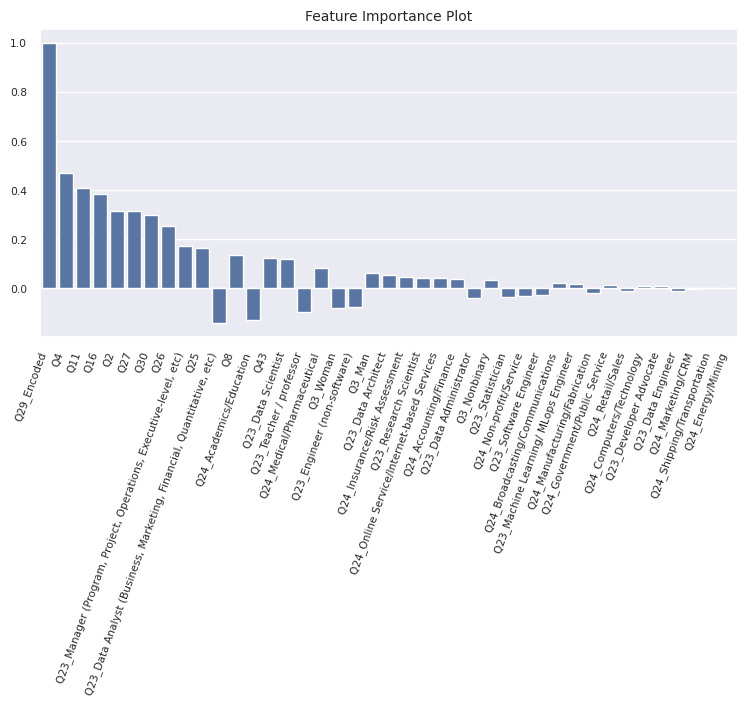

In [ ]:
#barplot of feature importance
plt.figure(figsize=(9,4))
sns.set(font_scale=0.7)
plt.title('Feature Importance Plot',fontsize = 10)

ax2 = sns.barplot(x=features_important.index,y='Q29_Encoded',data=features_important)
ax2.set_xticklabels(ax2.get_xticklabels(),
                         rotation=70,
                         horizontalalignment='right')

ax2.set(xlabel=None,ylabel=None)
plt.show()

Features with higher correlation with target variables have stronger importance. Features Q4, Q11, Q16, Q2, Q27, Q30, Q26, Q23_Manager, Q25, Q23_Data Analyst are the top 10 most important features to predict salaries.

## **Feature Selection**

- Select the features based on the criteria of your choice

In [ ]:
#use Chi-square to select top 30 features
chi_selector = SelectKBest(score_func=chi2, k=30)
features_set_new = chi_selector.fit_transform(features_set, target)
#get the selected features name
selected_features = df.columns.values[:-1][chi_selector.get_support()]

print('Selected features:')
print(selected_features)

Selected features:
['Q2' 'Q4' 'Q6_5' 'Q11' 'Q12_9' 'Q13_9' 'Q14_12' 'Q16' 'Q17_6' 'Q17_7'
 'Q17_13' 'Q18_3' 'Q21_3' 'Q25' 'Q26' 'Q27' 'Q28_3' 'Q28_4' 'Q28_5' 'Q30'
 'Q31_1' 'Q33_1' 'Q34_3' 'Q35_2' 'Q35_6' 'Q35_10' 'Q42_1' 'Q43'
 'Q23_Data Analyst (Business, Marketing, Financial, Quantitative, etc)'
 'Q23_Manager (Program, Project, Operations, Executive-level, etc)']


In [ ]:
train_df_selected = train_df[selected_features]

## **Apply the same feature engineering/selection to test data**

In [ ]:
#TODO: Feature generation code you applied to the training data (optional)

# Leave selected features
test_df_selected = test_df[selected_features]

In [ ]:
X_train = train_df_selected.values
X_test = test_df_selected.values
y_train = y_train.values
y_test = y_test.values

# Question 3: Model Implementation

## Implement Ordinal Logistic Regression Model

In [ ]:
class OrdinalLogisticRegression():
    # TODO: Add ordinal logreg hyperparameters as args to __init__
    # A dummy hyperparameter is put as a placeholder for now
    def __init__(self, max_iter=100, C=1.0, solver='lbfgs'):
        self.C = C #TODO
        self.max_iter = max_iter
        self.solver = solver

        self.classes_ = []
        self.models_ = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        self.models_ = []

        # Train k-1 binary logistic regression models
        for i, c in enumerate(self.classes_[:-1]): # We need only k-1 classifiers
            y_i = (y > c).astype(int) # TODO: label is 0 if the salary bucket is 0 to c, otherwise label is 1
            model = LogisticRegression(max_iter=self.max_iter,C=self.C, solver=self.solver) # TODO: what machine learning model should be here?
            model.fit(X, y_i)
            self.models_.append(model)

        return self

    def predict_proba(self, X):
        assert len(self.models_) > 0, "Model is not fitted yet. Run .fit() first."

        # Predicted probabilities for k-1 binary logistic regression models (initialize placeholders)
        binary_probabilities = np.empty((X.shape[0], len(self.models_), 2), dtype=float)

        # Make predictions of k-1 binary logistic regression models
        for i, model in enumerate(self.models_):
            binary_probabilities[:, i] = model.predict_proba(X) #TODO: predicted **probabilities** by the ith binary logistic regression model

        # Compute the probabilities to be in each class
        k = len(self.classes_)
        proba = np.empty((X.shape[0], k), dtype=float) # predicted probabilities for all the data in X (shape=(X.shape[0], k))

        proba[:, 0] = binary_probabilities[:, 0, 0] # 0th probability

        for i in range(1, k-1):
            # ith probability
            # (prob of belonging to class 0 for the ith model - prob of belonging to class 0 for the (i-1)th model
            proba[:, i] = binary_probabilities[:, i, 0] - binary_probabilities[:, i-1, 0]

        proba[:, -1] = binary_probabilities[:, k-2, 1] # (k-1)th probability

        assert (proba.sum(axis=1) == 1).all(), \
            'There is a problem in the probability computation'
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis = 1)

    # Add hyperparameters here whenever you add new ones
    # max_iter is added as an example here. key is the hyperparameter name,
    # and value is the attribute name you defined in this class
    def get_params(self, deep=True):
        return {'max_iter': self.max_iter,
                'C': self.C,
                'solver': self.solver}

    # DO NOT CHANGE
    def set_params(self, **parameters):
        # Set estimator parameters
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

## Run k-fold cross validation

- Report the average/variance of accuracies across folds

In [ ]:
accuracies = []

#TODO: Perform 10-fold cross validation
model = OrdinalLogisticRegression()
#define 10 fold
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
kfold.get_n_splits(X_train)
fold_num = 0

for train_idx, test_idx in kfold.split(X_train):
    X_train_1, X_val = X_train[train_idx], X_train[test_idx]
    y_train_1, y_val = y_train[train_idx], y_train[test_idx]

    #train & evaluate model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    #get accuracy score
    acc = (np.mean(y_pred == y_val))*100
    accuracies.append(acc)

    fold_num += 1
    print("Fold {} Accuracy: {}%".format(fold_num, round(acc,3)))

print("Average accuracy    : {}%".format( np.mean(accuracies)))
print("Variance of accuracy: ", np.var(accuracies))

Fold 1 Accuracy: 42.281%
Fold 2 Accuracy: 42.105%
Fold 3 Accuracy: 43.684%
Fold 4 Accuracy: 41.93%
Fold 5 Accuracy: 43.158%
Fold 6 Accuracy: 39.719%
Fold 7 Accuracy: 40.246%
Fold 8 Accuracy: 37.961%
Fold 9 Accuracy: 42.882%
Fold 10 Accuracy: 41.828%
Average accuracy    : 41.57940986032744%
Variance of accuracy:  2.79021674189634


## Bias-variance trade-off

[bias_variance_decomp.py](https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/bias_variance_decomp.py)

Below is a function you can use to compute the bias and variance of your ordinal logistic regression model. Using this function, analyze the ordinal logistic regression model performance based on bias-variance trade-off.

In [ ]:
def _draw_bootstrap_sample(rng, X, y):
    sample_indices = np.arange(X.shape[0])
    bootstrap_indices = rng.choice(
        sample_indices, size=sample_indices.shape[0], replace=True
    )
    return X[bootstrap_indices], y[bootstrap_indices]

def bias_variance_decomp(
    estimator,
    X_train,
    y_train,
    X_test,
    y_test,
    num_rounds=10,
    random_seed=0
):
    """
    estimator : object
        A classifier or regressor object or class implementing both a
        `fit` and `predict` method similar to the scikit-learn API.

    X_train : array-like, shape=(num_examples, num_features)
        A training dataset for drawing the bootstrap samples to carry
        out the bias-variance decomposition.

    y_train : array-like, shape=(num_examples)
        Targets (class labels, continuous values in case of regression)
        associated with the `X_train` examples.

    X_test : array-like, shape=(num_examples, num_features)
        The test dataset for computing the average loss, bias,
        and variance.

    y_test : array-like, shape=(num_examples)
        Targets (class labels, continuous values in case of regression)
        associated with the `X_test` examples.

    num_rounds : int (default=10)
        Number of bootstrap rounds (sampling from the training set)
        for performing the bias-variance decomposition. Each bootstrap
        sample has the same size as the original training set.

    random_seed : int (default=0)
        Random seed for the bootstrap sampling used for the
        bias-variance decomposition.

    Returns
    ----------
    avg_bias, avg_var : returns the average bias, and average bias (all floats),
                        where the average is computed over the data points
                        in the test set.

    """
    loss = "mse"

    for ary in (X_train, y_train, X_test, y_test):
        assert type(ary) == np.ndarray, \
            "X_train, y_train, X_test, y_test have to be NumPy array. \
            If e.g., X_train is a pandas DataFrame, convert it to NumPy array \
            via X_train=X_train.values."

    rng = np.random.RandomState(random_seed)

    # All the predictions across different rounds
    all_pred = np.zeros((num_rounds, y_test.shape[0]), dtype=np.float64)

    for i in range(num_rounds):
        # Randomly sample training data
        X_boot, y_boot = _draw_bootstrap_sample(rng, X_train, y_train)

        # Fit the model using the randomly sampled data
        pred = estimator.fit(X_boot, y_boot).predict(X_test)
        all_pred[i] = pred

    # Mean prediction across runs using different dataset for each data point
    main_predictions = np.mean(all_pred, axis=0)

    # Average bias across different rounds
    avg_bias = np.sum((main_predictions - y_test) ** 2) / y_test.size

    # Average variance across different rounds
    avg_var = np.sum((main_predictions - all_pred) ** 2) / all_pred.size

    return avg_bias, avg_var

In [ ]:
# Usage example
model = OrdinalLogisticRegression()
avg_bias, avg_var = \
    bias_variance_decomp(model, X_train, y_train, X_test, y_test, num_rounds=10, random_seed=0)

In [ ]:
print(avg_bias, avg_var)

16.03767308480131 1.5316837361736995


Hyperparameter C has a direct impact on the bias-variance trade-off.

In [ ]:
#Discuss bias-variance trade-off of your ordinal logistic regression model
#try different C values
C_list = [0.0001,0.001,0.01,0.1,1,10,100,1000]

#record results
bias_list = []
var_list = []
mse_list = []

for c in C_list:
  #build model with different C values
  model = OrdinalLogisticRegression(C=c)
  #compute bias & variance
  avg_bias, avg_var = \
    bias_variance_decomp(model, X_train, y_train, X_test, y_test, num_rounds=10, random_seed=0)
  bias_list.append(avg_bias)
  var_list.append(avg_var)
  mse_list.append(avg_bias + avg_var)

In [ ]:
#bias result
print("Bias:", bias_list)

Bias: [31.837591151167555, 22.4655223269152, 18.460467021712414, 16.40129045473167, 16.03767308480131, 16.005813191315035, 16.017038099139697, 16.020856206472757]


In [ ]:
#variance result
print("Variance:", var_list)

Variance: [0.12791478902089307, 0.8459893486276115, 1.2545678000819336, 1.456104055714871, 1.5316837361736995, 1.607501024170422, 1.6128267103646046, 1.6097460057353543]


In [ ]:
#MSE result
print("MSE:", mse_list)

MSE: [31.965505940188446, 23.31151167554281, 19.715034821794347, 17.85739451044654, 17.56935682097501, 17.613314215485456, 17.6298648095043, 17.63060221220811]


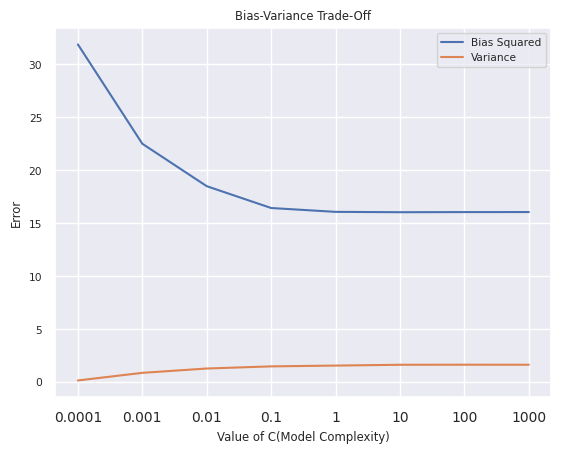

In [ ]:
#plot bias & variance
plt.plot(bias_list, label="Bias Squared")
plt.plot(var_list, label="Variance")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], C_list, fontsize = 10)
plt.legend()
plt.xlabel('Value of C(Model Complexity)')
plt.ylabel('Error')
plt.title("Bias-Variance Trade-Off")
plt.show()

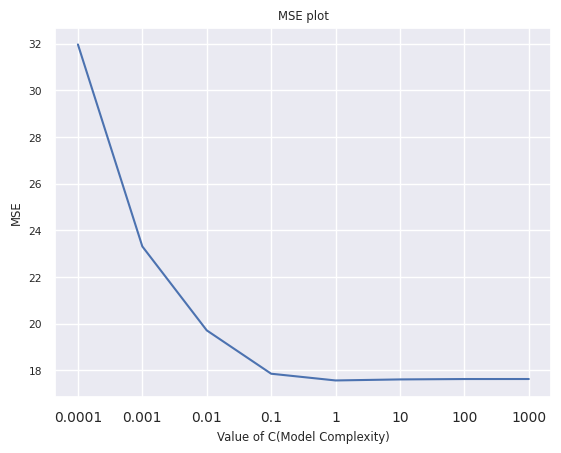

In [ ]:
#plot MSE
plt.plot(mse_list)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], C_list, fontsize = 10)
plt.xlabel('Value of C(Model Complexity)')
plt.ylabel('MSE')
plt.title("MSE plot")
plt.show()

From the graphs, as C gets larger, the regularization effect decreases and hence model complexity increases. As model complexity increases, bias decreases variance increases.

The best value of C is 1. We want to avoid high bias because the model would be too simple and avoid high variance becasue the model would be complex to generalize on unseen data. Thus, we select the best C when bias and variance are minimized as much as possible, in other words, when MSE is minimized.

# Question 4: Model Tuning

In [ ]:
#distribution of target
df['Q29_Encoded'].value_counts()

0.0     3058
1.0      792
2.0      614
3.0      464
4.0      421
10.0     404
5.0      366
12.0     342
6.0      318
7.0      289
11.0     269
13.0     233
8.0      222
9.0      197
14.0     147
Name: Q29_Encoded, dtype: int64

From the distribution of target variable, we know that this dataset is highly imbalanced with over 37% is encoded as 0. So accuracy is not suitable in this case because the model can achieve high accuracy by always predicting the majority class. I chose F1 score as the proper criterion becasue it is a harmonic mean of precision and recall.

- What are the hyperparameters we can potentially set for our ordinal logistic regression model?
- Which hyperparameters seem to be worthwhile to tune?

Possible hyperparameters include penalty, dual, tol, C, fit_intercept, intercept_scaling, class_weight, random_state, solver, max_iter, multi_class,verbose, warm_start, n_jobs, l1_ratio.

I chose C and solver for model tuning.

## Grid Search

- Grid search will take time to complete - but if it does not finish in a few hours, you're probably trying too many combinations
- A recommended approach is to try a small number of combinations with a wide range first (for continuous value hyperparameters)! Then gradually increase the points that seem to be near optimal

In [ ]:
from sklearn.model_selection import GridSearchCV

#Perform grid search using a proper criteria and identify the best parameter set
model = OrdinalLogisticRegression()
#define range of values for parameters we want to search
param = {'C':[0.0001,0.001,0.01,0.1,1,10,100,1000],
         'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

gridsearch = GridSearchCV(estimator=model, param_grid=param, cv=10, scoring='f1_macro')
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=<__main__.OrdinalLogisticRegression object at 0x791a5393d120>,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='f1_macro')

In [ ]:
print("Best parameters from gridsearch: {}".format(gridsearch.best_params_))
print("Best F1 score: {}".format(gridsearch.best_score_))

Best parameters from gridsearch: {'C': 1000, 'solver': 'lbfgs'}
Best F1 score: 0.10551745950172065


In [ ]:
#compute F1 score before tuning for comparison
from sklearn.metrics import f1_score

f1_list = []
model_before = OrdinalLogisticRegression()
#define 10 fold
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
kfold.get_n_splits(X_train)
fold_num = 0

for train_idx, test_idx in kfold.split(X_train):
    X_train_1, X_val = X_train[train_idx], X_train[test_idx]
    y_train_1, y_val = y_train[train_idx], y_train[test_idx]

    #train & evaluate model
    model_before.fit(X_train, y_train)
    y_pred = model_before.predict(X_val)

    #get f1 score
    f1 = f1_score(y_val, y_pred, average='macro')
    f1_list.append(f1)

    fold_num += 1
    print("Fold {} F1 Score: {}".format(fold_num, round(f1,3)))

print("F1 Score before tuning: {}".format(np.mean(f1_list)))

Fold 1 F1 Score: 0.136
Fold 2 F1 Score: 0.134
Fold 3 F1 Score: 0.151
Fold 4 F1 Score: 0.117
Fold 5 F1 Score: 0.146
Fold 6 F1 Score: 0.109
Fold 7 F1 Score: 0.143
Fold 8 F1 Score: 0.095
Fold 9 F1 Score: 0.177
Fold 10 F1 Score: 0.135
F1 Score before tuning: 0.13437334785505123


The best set of parameters are C=1000 and solver=lbfgs. The best F1 score is 0.10551745950172065 while the F1 score before tuning is 0.13437334785505123.

## Visualize the feature importance of your model

I use model coefficients to represent feature importance in ordinal logistic regression. The bigger the magnitude of an coefficient indicates more importance for a feature. Since we have k-1 classifiers and each classifier has one set of coefficients, I decided to use the average coefficients across classifiers as the coefficients for features.

In [ ]:
#set the best-performing hyperparameters identified via grid search
best_model = OrdinalLogisticRegression(C=1000, solver='lbfgs')
#fit model
best_model = best_model.fit(X_train, y_train)
#calculate average coef across 14 classifiers
coef = np.zeros(len(best_model.models_[0].coef_[0]))
for i in range(len(best_model.models_)):
  coef = np.add(best_model.models_[i].coef_[0], coef)

coef = coef/len(best_model.models_)

In [ ]:
#attach features name for interpretation
df_importance = pd.DataFrame(data=coef, index=selected_features, columns=['Coef'])
df_importance = df_importance.sort_values(by='Coef',key=abs,ascending = False)
df_importance

,Coef
"Q23_Manager (Program, Project, Operations, Executive-level, etc)",0.807625
Q4,0.745099
Q35_6,0.486688
Q42_1,-0.471615
Q6_5,0.471079
Q35_10,0.385983
Q21_3,0.344869
Q28_5,0.247764
Q34_3,0.214576
Q31_1,0.212941


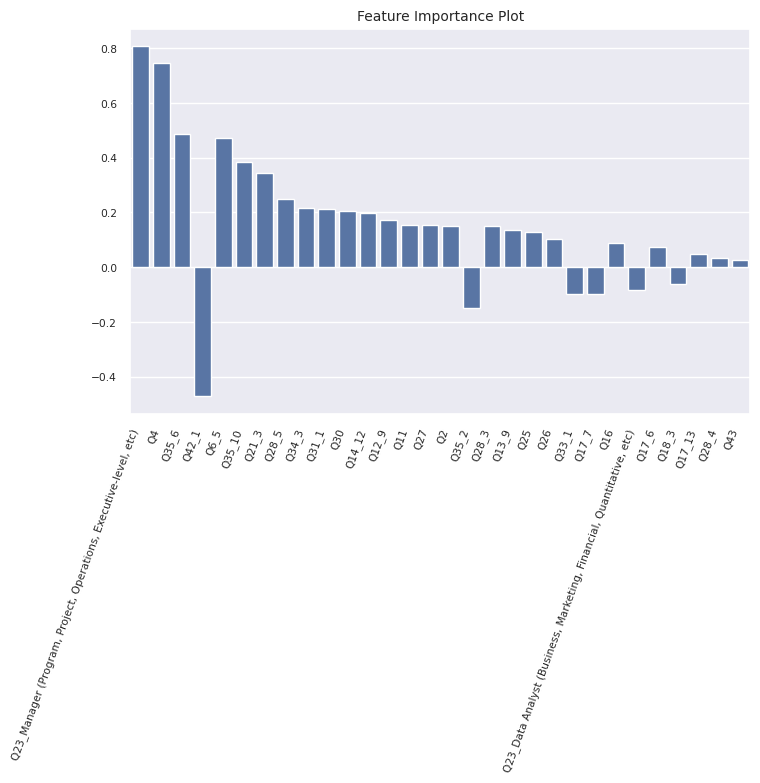

In [ ]:
#Visualize feature importance of the ordinal logistic regression model
plt.figure(figsize=(8,5))
plt.title('Feature Importance Plot',fontsize = 10)
ax3 = sns.barplot(x=df_importance.index, y='Coef', data=df_importance)
ax3.set_xticklabels(ax3.get_xticklabels(),
                         rotation=70,
                         horizontalalignment='right')
ax3.set(xlabel=None, ylabel=None)
plt.show()

Top 10 important features are Q23_Manager, Q4, Q35_6, Q42_1, Q6_5, Q35_10, Q21_3, Q28_5, Q34_3, Q31_1.
The graphs are different.

# Question 5: Testing

In [ ]:
#Using the best-performing model, evaluate the model performance both on the training set and test set
#fit the best model
best_model = OrdinalLogisticRegression(C=1000, solver='lbfgs')
best_model = best_model.fit(X_train, y_train)
#predict on training & test set
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
#F1 score
f1_train = f1_score(y_train, y_train_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')

print('F1 score for training set: {}'.format(f1_train))
print('F1 score for test set: {}'.format(f1_test))

F1 score for training set: 0.1381244124856424
F1 score for test set: 0.10818145048985282


The model does not perform well. The model is underfitting because the overall F1 score for both training set and test set is low. This is because the dataset is imbalanced and model complexity is not enough. To improve model performance, I would upsample the minority classes to make the dataset more balanced. During feature selection, I will increase number of features.

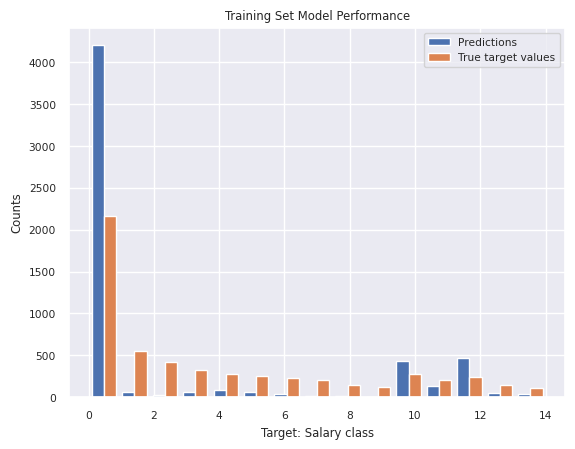

In [ ]:
#Plot the distribution of true target variable values and their predictions on both the training set and test set
plt.hist([y_train_pred,y_train],bins=15,
         label=['Predictions','True target values'])
plt.xlabel('Target: Salary class')
plt.ylabel('Counts')
plt.title('Training Set Model Performance')
plt.legend()
plt.show()

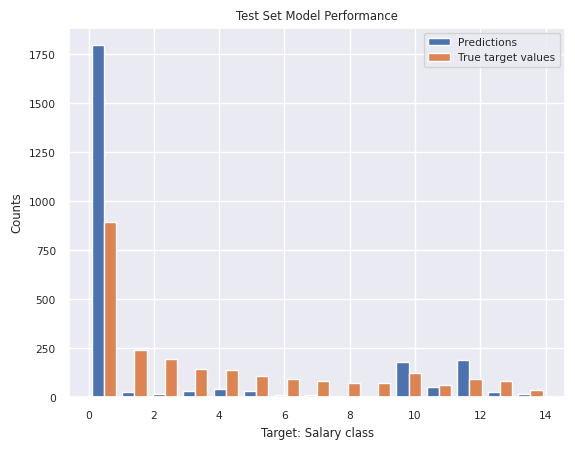

In [ ]:
plt.hist([y_test_pred,y_test],bins=15,
         label=['Predictions','True target values'])
plt.xlabel('Target: Salary class')
plt.ylabel('Counts')
plt.title('Test Set Model Performance')
plt.legend()
plt.show()

The distribution of true target values and their predictions on both training set and test set are similar. This dataset is highly imbalanced with class 0 dominating other classes. Most predictions are also class 0 but the number of prediction on class 0 is much more than the number of true target values. Meanwhile, for minority classes like class 2 and class 6, the number of predictions is much smaller than its true target values. This suggests the classification model is not trained well because it learns to predict class 0 for most of the time and seldom predicts minority classes. It should learn to discrimnate different classes but from the distribution plot, my model does not achieve this goal.